In [9]:
import jax.numpy as np
from jax import random

import numpyro
from numpyro.infer import SVI, Trace_ELBO, autoguide, init_to_value, init_to_median, Predictive
import numpyro.distributions as dist

from grassgp.inference import run_inference


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [14]:
def model(n, data):
    assert len(data) == n
    m = numpyro.sample("m", dist.Normal(0, 1))
    sd = numpyro.sample("sd", dist.LogNormal(m, 1))
    left_means = -1*np.ones(n//2)
    right_means = 3*np.ones(n - n//2)
    plate_means = np.concatenate((left_means,right_means))
    with numpyro.plate("N", n):
        numpyro.sample("obs", dist.Normal(plate_means, sd), obs=data)

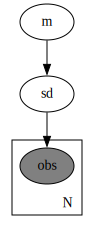

In [16]:
n = 10
data = np.concatenate((-1*np.ones(n//2), 3*np.ones(n - n//2)))
numpyro.render_model(model, model_args=(n,data))

In [17]:
train_key = random.PRNGKey(23523)
mcmc_config = {'num_warmup' : 1000, 'num_samples' : 1000, 'num_chains' : 1, 'thinning' : 2, 'init_strategy' : init_to_median(num_samples=10)}
mcmc = run_inference(train_key, mcmc_config, model, n, data)

samples = mcmc.get_samples()

sample: 100%|█| 2000/2000 [00:04<00:00, 427.43it/s, 7 steps of size 6.14e-01. ac


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m    -10.07      1.01    -10.13    -11.59     -8.42    267.75      1.00
        sd      0.00      0.00      0.00      0.00      0.00    467.92      1.00

Number of divergences: 0

MCMC elapsed time: 4.818146467208862


In [41]:
def predictive_model(n):
    m = numpyro.sample("m", dist.Normal(0, 1))
    sd = numpyro.sample("sd", dist.LogNormal(m, 1))
    left_means = -1*np.ones(n//2)
    right_means = 3*np.ones(n - n//2)
    plate_means = np.concatenate((left_means,right_means))
    with numpyro.plate("N", n):
        numpyro.sample("obs", dist.Normal(plate_means, sd))

In [45]:
key = random.PRNGKey(235)
prior = Predictive(predictive_model, num_samples=1)
pred = prior(key,n=n)
print(pred)

{'m': DeviceArray([-0.2162705], dtype=float32), 'obs': DeviceArray([[-1.7723205 , -0.8691286 , -0.57075214, -0.3190559 ,
              -1.6601727 ,  2.846188  ,  3.0078752 ,  3.2083263 ,
               2.4255238 ,  2.486383  ]], dtype=float32), 'sd': DeviceArray([0.5412863], dtype=float32)}


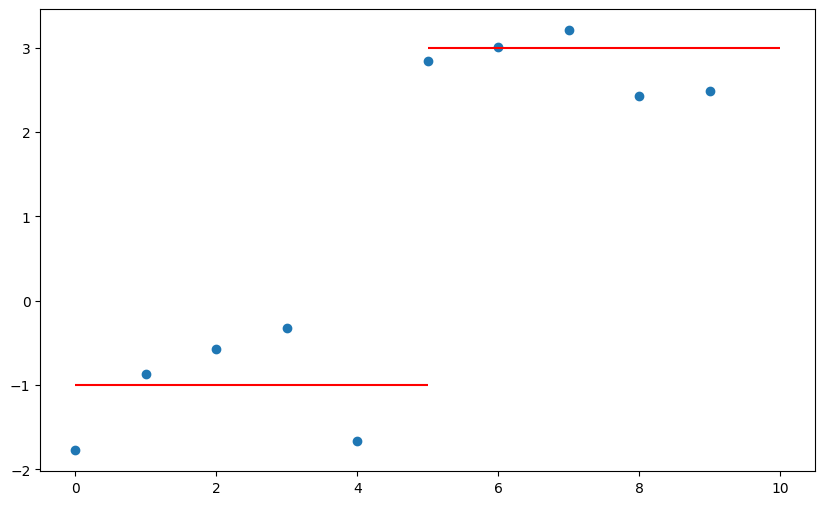

In [44]:
plt.scatter(range(n),pred['obs'])
plt.hlines(-1,0,5,colors='r')
plt.hlines(3,5,10,colors='r')
plt.show()